# Rule-Based System Error Analysis vs BERT Performance

## Overview
This notebook analyzes the instances where the rule-based (RB) relation extraction system made incorrect predictions and compares them with BERT's performance on the same instances. The goal is to identify patterns in RB failures, understand where BERT provides improvements, and discover cases that remain challenging for both approaches.

## Notebook Steps

### 1. **Data Loading**
   - Load BERT test predictions (`bert_test_detailed_predictions.csv`)
   - Load Rule-Based test predictions (`rb_test_detailed_predictions.csv`)
   - Verify data alignment and calculate baseline accuracies

### 2. **Error Identification**
   - Filter instances where the rule-based system made incorrect predictions
   - Analyze error distribution across the test set

### 3. **Comparative Analysis**
   - Merge RB errors with corresponding BERT predictions
   - Calculate how many RB errors BERT correctly predicts
   - Identify cases where both models fail

### 4. **Relation-Type Breakdown**
   - Analyze which relation types are most problematic for RB
   - Calculate BERT's accuracy on each relation type's RB errors
   - Visualize error distributions and BERT recovery rates

### 5. **Success Pattern Analysis**
   - Examine cases where RB failed but BERT succeeded
   - Identify patterns in these successful BERT predictions
   - Review the rules that triggered incorrectly in RB

### 6. **Hard Cases Analysis**
   - Identify instances where both RB and BERT failed
   - Analyze common characteristics of these challenging cases
   - Determine which relations are universally difficult

### 7. **RB Prediction Patterns**
   - Analyze what the RB system predicts when it's wrong
   - Visualize the distribution of incorrect predictions

### 8. **Confusion Analysis**
   - Create confusion pairs showing true vs predicted relations
   - Identify the most common RB misclassifications

### 9. **Comprehensive CSV Export**
   - Generate `rb_errors_with_bert_predictions.csv` containing:
     - Original text and entities
     - True relation labels
     - RB predictions with rule explanations
     - BERT predictions with confidence scores
     - Correctness indicators
   - This CSV enables detailed manual inspection of error patterns

### 10. **Summary Statistics**
   - Export overall performance metrics
   - Calculate improvement rates
   - Generate final insights

## Expected Outputs
- **CSV Files**: 
  - `rb_errors_with_bert_predictions.csv` - Comprehensive comparison with rule explanations
  - `rb_errors_bert_comparison.csv` - Simple comparison file
- **Visualizations**: 
  - Error distribution by relation type
  - BERT recovery rate charts
  - Confusion pattern analysis
- **Insights**: 
  - Identification of RB's weakest relation types
  - Quantification of BERT's improvement
  - Analysis of universally challenging cases

In [3]:
import csv
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [6]:
# Load BERT predictions
bert_df = pd.read_csv('./bert implementation/bert_test_detailed_predictions.csv')

# Load Rule-Based predictions
rb_df = pd.read_csv('../data/predictions/milestone_2/rb_test_detailed_predictions.csv')

print(f"BERT predictions: {len(bert_df)} instances")
print(f"Rule-based predictions: {len(rb_df)} instances")
print(f"\nBERT accuracy: {(bert_df['is_correct'] == True).sum() / len(bert_df):.4f}")
print(f"Rule-based accuracy: {(rb_df['is_correct'] == True).sum() / len(rb_df):.4f}")

BERT predictions: 2717 instances
Rule-based predictions: 2717 instances

BERT accuracy: 0.8336
Rule-based accuracy: 0.4965


## 2. Filter Rule-Based Errors

In [7]:
# Get instances where rule-based system was wrong
rb_errors = rb_df[rb_df['is_correct'] == False].copy()

print(f"Rule-based errors: {len(rb_errors)} instances ({len(rb_errors)/len(rb_df)*100:.2f}%)")
print(f"\nFirst few errors:")
rb_errors.head()

Rule-based errors: 1368 instances (50.35%)

First few errors:


,id,text,e1,e2,true_relation,predicted_relation,predicted_direction,rule_explanation,is_correct
1,8002,The company fabricates plastic chairs.,company,chairs,"Product-Producer(e2,e1)",Other,NaN,No high-precision rule matched; defaulting to ...,False
2,8003,The school master teaches the lesson with a st...,master,stick,"Instrument-Agency(e2,e1)",Other,NaN,No high-precision rule matched; defaulting to ...,False
5,8006,The ear of the African elephant is significant...,ear,elephant,"Component-Whole(e1,e2)",Other,NaN,No high-precision rule matched; defaulting to ...,False
6,8007,A child is told a lie for several years by the...,lie,parents,"Product-Producer(e1,e2)",Other,NaN,No high-precision rule matched; defaulting to ...,False
7,8008,"Skype, a free software, allows a hookup of mul...",hookup,users,"Member-Collection(e2,e1)",Other,NaN,No high-precision rule matched; defaulting to ...,False


## 3. Compare with BERT on Same Instances

In [8]:
# Merge to compare predictions on the same instances
comparison_df = rb_errors.merge(
    bert_df[['id', 'predicted_relation', 'predicted_direction', 'model_confidence', 'is_correct']], 
    on='id', 
    suffixes=('_rb', '_bert')
)

print(f"Total instances where rule-based was wrong: {len(comparison_df)}")
print(f"\nOf these, BERT got correct: {comparison_df['is_correct_bert'].sum()} ({comparison_df['is_correct_bert'].sum()/len(comparison_df)*100:.2f}%)")
print(f"Both wrong: {(comparison_df['is_correct_bert'] == False).sum()} ({(comparison_df['is_correct_bert'] == False).sum()/len(comparison_df)*100:.2f}%)")

comparison_df.head(10)

Total instances where rule-based was wrong: 1368

Of these, BERT got correct: 1038 (75.88%)
Both wrong: 330 (24.12%)


,id,text,e1,e2,true_relation,predicted_relation_rb,predicted_direction_rb,rule_explanation,is_correct_rb,predicted_relation_bert,predicted_direction_bert,model_confidence,is_correct_bert
0,8002,The company fabricates plastic chairs.,company,chairs,"Product-Producer(e2,e1)",Other,NaN,No high-precision rule matched; defaulting to ...,False,"Product-Producer(e2,e1)",NaN,0.982391,True
1,8003,The school master teaches the lesson with a st...,master,stick,"Instrument-Agency(e2,e1)",Other,NaN,No high-precision rule matched; defaulting to ...,False,"Instrument-Agency(e2,e1)",NaN,0.981765,True
2,8006,The ear of the African elephant is significant...,ear,elephant,"Component-Whole(e1,e2)",Other,NaN,No high-precision rule matched; defaulting to ...,False,"Component-Whole(e1,e2)",NaN,0.985363,True
3,8007,A child is told a lie for several years by the...,lie,parents,"Product-Producer(e1,e2)",Other,NaN,No high-precision rule matched; defaulting to ...,False,"Product-Producer(e1,e2)",NaN,0.554236,True
4,8008,"Skype, a free software, allows a hookup of mul...",hookup,users,"Member-Collection(e2,e1)",Other,NaN,No high-precision rule matched; defaulting to ...,False,"Member-Collection(e2,e1)",NaN,0.625520,True
5,8009,The disgusting scene was retaliation against h...,room,house,"Component-Whole(e1,e2)",Other,NaN,No high-precision rule matched; defaulting to ...,False,"Component-Whole(e1,e2)",NaN,0.940313,True
6,8014,"As a landscape company in Atlanta, we know whi...",landscape,company,"Product-Producer(e1,e2)",Other,NaN,No high-precision rule matched; defaulting to ...,False,"Product-Producer(e1,e2)",NaN,0.898203,True
7,8019,Beneath this invocation there is a zoo of fear...,zoo,beasts,"Member-Collection(e2,e1)",Other,NaN,No high-precision rule matched; defaulting to ...,False,"Member-Collection(e2,e1)",NaN,0.984047,True
8,8020,The song was composed for a famous Brazilian m...,song,musician,"Product-Producer(e1,e2)",Other,NaN,No high-precision rule matched; defaulting to ...,False,"Product-Producer(e1,e2)",NaN,0.955406,True
9,8023,I spent a year working for a software company ...,software,company,"Product-Producer(e1,e2)",Other,NaN,No high-precision rule matched; defaulting to ...,False,"Product-Producer(e1,e2)",NaN,0.818080,True


## 4. Breakdown by Relation Type

In [9]:
# Analyze errors by true relation type
error_by_relation = comparison_df.groupby('true_relation').agg({
    'id': 'count',
    'is_correct_bert': 'sum'
}).rename(columns={'id': 'rb_errors', 'is_correct_bert': 'bert_correct_on_rb_errors'})

error_by_relation['bert_accuracy_on_rb_errors'] = (
    error_by_relation['bert_correct_on_rb_errors'] / error_by_relation['rb_errors'] * 100
)

error_by_relation = error_by_relation.sort_values('rb_errors', ascending=False)
print("\nRule-based errors by relation type (and BERT's performance on those):")
error_by_relation


Rule-based errors by relation type (and BERT's performance on those):


,rb_errors,bert_correct_on_rb_errors,bert_accuracy_on_rb_errors
true_relation,,,
Other,238,110,46.218487
"Member-Collection(e2,e1)",179,159,88.826816
"Component-Whole(e1,e2)",156,132,84.615385
"Component-Whole(e2,e1)",94,73,77.659574
"Message-Topic(e1,e2)",94,87,92.553191
"Product-Producer(e1,e2)",92,79,85.869565
"Product-Producer(e2,e1)",78,64,82.051282
"Instrument-Agency(e2,e1)",74,54,72.972973
"Entity-Origin(e1,e2)",67,50,74.626866


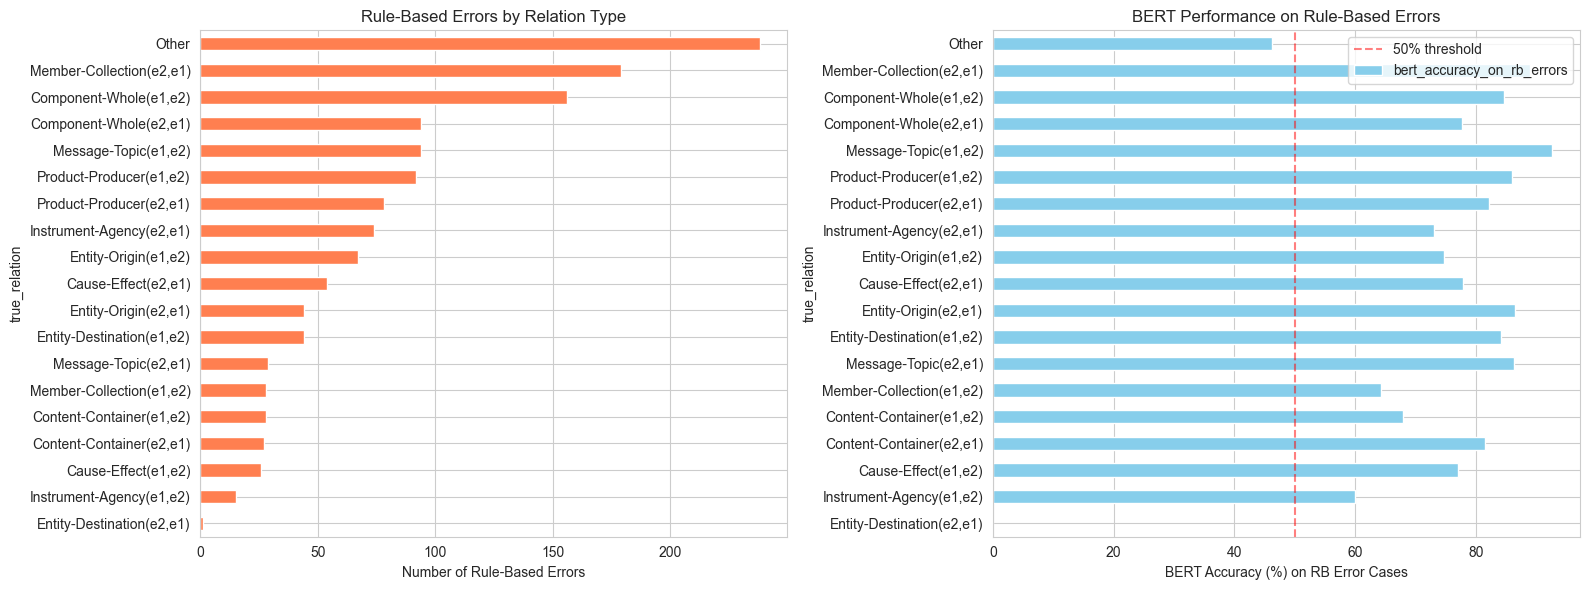

In [10]:
# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Number of RB errors by relation
error_by_relation['rb_errors'].plot(kind='barh', ax=ax1, color='coral')
ax1.set_xlabel('Number of Rule-Based Errors')
ax1.set_title('Rule-Based Errors by Relation Type')
ax1.invert_yaxis()

# Plot 2: BERT accuracy on RB errors
error_by_relation['bert_accuracy_on_rb_errors'].plot(kind='barh', ax=ax2, color='skyblue')
ax2.set_xlabel('BERT Accuracy (%) on RB Error Cases')
ax2.set_title('BERT Performance on Rule-Based Errors')
ax2.invert_yaxis()
ax2.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
ax2.legend()

plt.tight_layout()
plt.show()

## 5. Identify Patterns in RB Errors that BERT Solves

In [11]:
# Cases where RB was wrong but BERT was correct
rb_wrong_bert_right = comparison_df[comparison_df['is_correct_bert'] == True].copy()

print(f"Cases where RB failed but BERT succeeded: {len(rb_wrong_bert_right)}")
print(f"\nBreakdown by true relation:")
print(rb_wrong_bert_right['true_relation'].value_counts())

Cases where RB failed but BERT succeeded: 1038

Breakdown by true relation:
true_relation
Member-Collection(e2,e1)     159
Component-Whole(e1,e2)       132
Other                        110
Message-Topic(e1,e2)          87
Product-Producer(e1,e2)       79
Component-Whole(e2,e1)        73
Product-Producer(e2,e1)       64
Instrument-Agency(e2,e1)      54
Entity-Origin(e1,e2)          50
Cause-Effect(e2,e1)           42
Entity-Origin(e2,e1)          38
Entity-Destination(e1,e2)     37
Message-Topic(e2,e1)          25
Content-Container(e2,e1)      22
Cause-Effect(e1,e2)           20
Content-Container(e1,e2)      19
Member-Collection(e1,e2)      18
Instrument-Agency(e1,e2)       9
Name: count, dtype: int64


In [12]:
# Show examples where BERT succeeded on RB errors
print("\n=== Examples: RB Wrong, BERT Correct ===")
for idx, row in rb_wrong_bert_right.head(10).iterrows():
    print(f"\nID: {row['id']}")
    print(f"Text: {row['text']}")
    print(f"Entities: {row['e1']} <-> {row['e2']}")
    print(f"True: {row['true_relation']}")
    print(f"RB predicted: {row['predicted_relation_rb']}")
    print(f"BERT predicted: {row['predicted_relation_bert']} (confidence: {row['model_confidence']:.4f})")
    print("-" * 80)


=== Examples: RB Wrong, BERT Correct ===

ID: 8002
Text: The company fabricates plastic chairs.
Entities: company <-> chairs
True: Product-Producer(e2,e1)
RB predicted: Other
BERT predicted: Product-Producer(e2,e1) (confidence: 0.9824)
--------------------------------------------------------------------------------

ID: 8003
Text: The school master teaches the lesson with a stick.
Entities: master <-> stick
True: Instrument-Agency(e2,e1)
RB predicted: Other
BERT predicted: Instrument-Agency(e2,e1) (confidence: 0.9818)
--------------------------------------------------------------------------------

ID: 8006
Text: The ear of the African elephant is significantly larger--measuring 183 cm by 114 cm in the bush elephant.
Entities: ear <-> elephant
True: Component-Whole(e1,e2)
RB predicted: Other
BERT predicted: Component-Whole(e1,e2) (confidence: 0.9854)
--------------------------------------------------------------------------------

ID: 8007
Text: A child is told a lie for several years

## 6. Identify Cases Where Both Failed

In [13]:
# Cases where both were wrong
both_wrong = comparison_df[comparison_df['is_correct_bert'] == False].copy()

print(f"Cases where both RB and BERT failed: {len(both_wrong)}")
print(f"\nBreakdown by true relation:")
print(both_wrong['true_relation'].value_counts())

Cases where both RB and BERT failed: 330

Breakdown by true relation:
true_relation
Other                        128
Component-Whole(e1,e2)        24
Component-Whole(e2,e1)        21
Member-Collection(e2,e1)      20
Instrument-Agency(e2,e1)      20
Entity-Origin(e1,e2)          17
Product-Producer(e2,e1)       14
Product-Producer(e1,e2)       13
Cause-Effect(e2,e1)           12
Member-Collection(e1,e2)      10
Content-Container(e1,e2)       9
Message-Topic(e1,e2)           7
Entity-Destination(e1,e2)      7
Instrument-Agency(e1,e2)       6
Entity-Origin(e2,e1)           6
Cause-Effect(e1,e2)            6
Content-Container(e2,e1)       5
Message-Topic(e2,e1)           4
Entity-Destination(e2,e1)      1
Name: count, dtype: int64


In [14]:
# Show examples where both failed
print("\n=== Examples: Both RB and BERT Wrong ===")
for idx, row in both_wrong.head(10).iterrows():
    print(f"\nID: {row['id']}")
    print(f"Text: {row['text']}")
    print(f"Entities: {row['e1']} <-> {row['e2']}")
    print(f"True: {row['true_relation']}")
    print(f"RB predicted: {row['predicted_relation_rb']}")
    print(f"BERT predicted: {row['predicted_relation_bert']} (confidence: {row['model_confidence']:.4f})")
    print("-" * 80)


=== Examples: Both RB and BERT Wrong ===

ID: 8027
Text: The same effect is achieved the traditional way, with a team of workers like Keebler elves.
Entities: effect <-> way
True: Cause-Effect(e2,e1)
RB predicted: Message-Topic(e1,e2)
BERT predicted: Other (confidence: 0.9876)
--------------------------------------------------------------------------------

ID: 8029
Text: He produces drawings and videos that have been shown in museums in Europe and America.
Entities: drawings <-> museums
True: Other
RB predicted: Cause-Effect(e2,e1)
BERT predicted: Message-Topic(e2,e1) (confidence: 0.9170)
--------------------------------------------------------------------------------

ID: 8034
Text: Essentially, the blisters that appear in the mouth are caused by the herpes simplex virus type 1, HSV-1 for short.
Entities: blisters <-> herpes simplex virus
True: Product-Producer(e1,e2)
RB predicted: Cause-Effect(e2,e1)
BERT predicted: Cause-Effect(e2,e1) (confidence: 0.9810)
-------------------------

## 7. RB Prediction Patterns on Errors

What did RB predict on its errors?
predicted_relation
Other                        813
Entity-Destination(e1,e2)     95
Content-Container(e1,e2)      69
Component-Whole(e2,e1)        63
Message-Topic(e1,e2)          63
Instrument-Agency(e2,e1)      54
Cause-Effect(e2,e1)           47
Product-Producer(e2,e1)       41
Entity-Origin(e1,e2)          36
Cause-Effect(e1,e2)           21
Member-Collection(e2,e1)      16
Message-Topic(e2,e1)          13
Component-Whole(e1,e2)        11
Product-Producer(e1,e2)        9
Instrument-Agency(e1,e2)       7
Member-Collection(e1,e2)       6
Entity-Origin(e2,e1)           2
Content-Container(e2,e1)       2
Name: count, dtype: int64


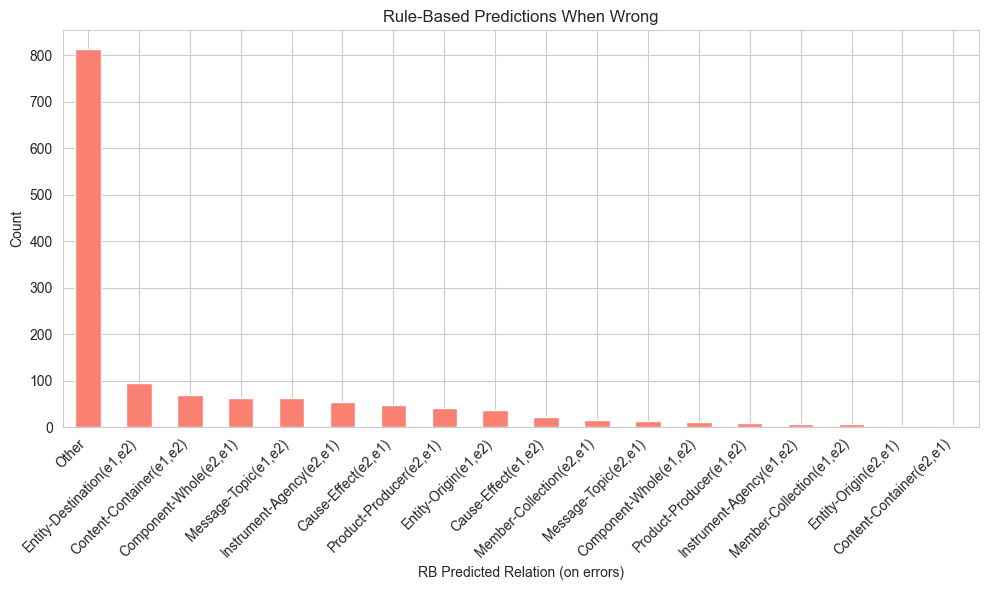

In [15]:
# What did RB predict when it was wrong?
print("What did RB predict on its errors?")
print(rb_errors['predicted_relation'].value_counts())

# Visualize
plt.figure(figsize=(10, 6))
rb_errors['predicted_relation'].value_counts().plot(kind='bar', color='salmon')
plt.xlabel('RB Predicted Relation (on errors)')
plt.ylabel('Count')
plt.title('Rule-Based Predictions When Wrong')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 8. Confusion Analysis

In [16]:
# Create confusion matrix for RB errors
confusion_pairs = rb_errors.groupby(['true_relation', 'predicted_relation']).size().reset_index(name='count')
confusion_pairs = confusion_pairs.sort_values('count', ascending=False)

print("Top 20 confusion pairs (True -> RB Predicted):")
print(confusion_pairs.head(20))

Top 20 confusion pairs (True -> RB Predicted):
                 true_relation         predicted_relation  count
103   Member-Collection(e2,e1)                      Other    158
24      Component-Whole(e1,e2)                      Other    137
33      Component-Whole(e2,e1)                      Other     69
111       Message-Topic(e1,e2)                      Other     67
159    Product-Producer(e2,e1)                      Other     57
127                      Other  Entity-Destination(e1,e2)     57
147    Product-Producer(e1,e2)                      Other     57
68        Entity-Origin(e1,e2)                      Other     51
88    Instrument-Agency(e2,e1)                      Other     45
76        Entity-Origin(e2,e1)                      Other     35
13         Cause-Effect(e2,e1)                      Other     32
125                      Other   Content-Container(e1,e2)     30
134                      Other       Message-Topic(e1,e2)     30
131                      Other   Instrument

## 10. Additional Export: Simple Comparison File

## 9. Create Comprehensive CSV for RB Errors with BERT Comparison

In [18]:
# Create a comprehensive CSV with RB errors and corresponding BERT predictions
# Including the rule_explanation from RB system

# Merge RB errors with BERT predictions, keeping rule_explanation
comprehensive_comparison = rb_errors[['id', 'text', 'e1', 'e2', 'true_relation', 
                                       'predicted_relation', 'predicted_direction', 
                                       'rule_explanation']].merge(
    bert_df[['id', 'predicted_relation', 'predicted_direction', 'model_confidence', 'is_correct']], 
    on='id', 
    suffixes=('_rb', '_bert')
)

# Rename columns for clarity (note: after merge, columns are named with suffix at the end)
comprehensive_comparison = comprehensive_comparison.rename(columns={
    'predicted_relation_rb': 'rb_predicted_relation',
    'predicted_direction_rb': 'rb_predicted_direction',
    'predicted_relation_bert': 'bert_predicted_relation',
    'predicted_direction_bert': 'bert_predicted_direction',
    'model_confidence': 'bert_confidence',
    'is_correct': 'bert_correct'
})

# Reorder columns for better readability
column_order = [
    'id', 'text', 'e1', 'e2', 
    'true_relation',
    'rb_predicted_relation', 'rb_predicted_direction', 'rule_explanation',
    'bert_predicted_relation', 'bert_predicted_direction', 'bert_confidence', 'bert_correct'
]
comprehensive_comparison = comprehensive_comparison[column_order]

print(f"Created comprehensive comparison with {len(comprehensive_comparison)} rule-based errors")
print(f"\nColumns included: {list(comprehensive_comparison.columns)}")
print(f"\nFirst few rows:")
comprehensive_comparison.head()

Created comprehensive comparison with 1368 rule-based errors

Columns included: ['id', 'text', 'e1', 'e2', 'true_relation', 'rb_predicted_relation', 'rb_predicted_direction', 'rule_explanation', 'bert_predicted_relation', 'bert_predicted_direction', 'bert_confidence', 'bert_correct']

First few rows:


,id,text,e1,e2,true_relation,rb_predicted_relation,rb_predicted_direction,rule_explanation,bert_predicted_relation,bert_predicted_direction,bert_confidence,bert_correct
0,8002,The company fabricates plastic chairs.,company,chairs,"Product-Producer(e2,e1)",Other,NaN,No high-precision rule matched; defaulting to ...,"Product-Producer(e2,e1)",NaN,0.982391,True
1,8003,The school master teaches the lesson with a st...,master,stick,"Instrument-Agency(e2,e1)",Other,NaN,No high-precision rule matched; defaulting to ...,"Instrument-Agency(e2,e1)",NaN,0.981765,True
2,8006,The ear of the African elephant is significant...,ear,elephant,"Component-Whole(e1,e2)",Other,NaN,No high-precision rule matched; defaulting to ...,"Component-Whole(e1,e2)",NaN,0.985363,True
3,8007,A child is told a lie for several years by the...,lie,parents,"Product-Producer(e1,e2)",Other,NaN,No high-precision rule matched; defaulting to ...,"Product-Producer(e1,e2)",NaN,0.554236,True
4,8008,"Skype, a free software, allows a hookup of mul...",hookup,users,"Member-Collection(e2,e1)",Other,NaN,No high-precision rule matched; defaulting to ...,"Member-Collection(e2,e1)",NaN,0.625520,True


In [19]:
# Save the comprehensive comparison CSV
output_path = '../data/predictions/milestone_2/rb_errors_with_bert_predictions.csv'
comprehensive_comparison.to_csv(output_path, index=False)

print(f"✓ Saved comprehensive CSV to: {output_path}")
print(f"\nThis CSV contains:")
print(f"  - {len(comprehensive_comparison)} instances where RB was wrong")
print(f"  - True relation labels")
print(f"  - RB predictions with rule explanations")
print(f"  - BERT predictions with confidence scores")
print(f"  - BERT correctness indicator")
print(f"\nOf these RB errors:")
print(f"  - BERT got {comprehensive_comparison['bert_correct'].sum()} correct ({comprehensive_comparison['bert_correct'].sum()/len(comprehensive_comparison)*100:.2f}%)")
print(f"  - Both failed on {(comprehensive_comparison['bert_correct'] == False).sum()} ({(comprehensive_comparison['bert_correct'] == False).sum()/len(comprehensive_comparison)*100:.2f}%)")

✓ Saved comprehensive CSV to: ../data/predictions/milestone_2/rb_errors_with_bert_predictions.csv

This CSV contains:
  - 1368 instances where RB was wrong
  - True relation labels
  - RB predictions with rule explanations
  - BERT predictions with confidence scores
  - BERT correctness indicator

Of these RB errors:
  - BERT got 1038 correct (75.88%)
  - Both failed on 330 (24.12%)


In [20]:
# Show some interesting examples from the comprehensive comparison

print("\n" + "="*80)
print("EXAMPLES: Cases where RB failed but BERT succeeded")
print("="*80)

rb_wrong_bert_right_samples = comprehensive_comparison[comprehensive_comparison['bert_correct'] == True].head(5)
for idx, row in rb_wrong_bert_right_samples.iterrows():
    print(f"\n[ID {row['id']}]")
    print(f"Text: {row['text'][:100]}..." if len(row['text']) > 100 else f"Text: {row['text']}")
    print(f"Entities: '{row['e1']}' <-> '{row['e2']}'")
    print(f"True Relation: {row['true_relation']}")
    print(f"RB Predicted: {row['rb_predicted_relation']}")
    print(f"  Rule: {row['rule_explanation']}")
    print(f"BERT Predicted: {row['bert_predicted_relation']} (confidence: {row['bert_confidence']:.4f}) ✓")
    print("-" * 80)

print("\n" + "="*80)
print("EXAMPLES: Cases where both RB and BERT failed")
print("="*80)

both_failed_samples = comprehensive_comparison[comprehensive_comparison['bert_correct'] == False].head(5)
for idx, row in both_failed_samples.iterrows():
    print(f"\n[ID {row['id']}]")
    print(f"Text: {row['text'][:100]}..." if len(row['text']) > 100 else f"Text: {row['text']}")
    print(f"Entities: '{row['e1']}' <-> '{row['e2']}'")
    print(f"True Relation: {row['true_relation']}")
    print(f"RB Predicted: {row['rb_predicted_relation']}")
    print(f"  Rule: {row['rule_explanation']}")
    print(f"BERT Predicted: {row['bert_predicted_relation']} (confidence: {row['bert_confidence']:.4f}) ✗")
    print("-" * 80)


EXAMPLES: Cases where RB failed but BERT succeeded

[ID 8002]
Text: The company fabricates plastic chairs.
Entities: 'company' <-> 'chairs'
True Relation: Product-Producer(e2,e1)
RB Predicted: Other
  Rule: No high-precision rule matched; defaulting to Other.
BERT Predicted: Product-Producer(e2,e1) (confidence: 0.9824) ✓
--------------------------------------------------------------------------------

[ID 8003]
Text: The school master teaches the lesson with a stick.
Entities: 'master' <-> 'stick'
True Relation: Instrument-Agency(e2,e1)
RB Predicted: Other
  Rule: No high-precision rule matched; defaulting to Other.
BERT Predicted: Instrument-Agency(e2,e1) (confidence: 0.9818) ✓
--------------------------------------------------------------------------------

[ID 8006]
Text: The ear of the African elephant is significantly larger--measuring 183 cm by 114 cm in the bush elep...
Entities: 'ear' <-> 'elephant'
True Relation: Component-Whole(e1,e2)
RB Predicted: Other
  Rule: No high-prec

In [21]:
# Save the comparison dataframe for further analysis
comparison_df.to_csv('../data/predictions/milestone_2/rb_errors_bert_comparison.csv', index=False)
print("Saved comparison to: data/predictions/milestone_2/rb_errors_bert_comparison.csv")

# Save summary statistics
summary = {
    'total_instances': len(rb_df),
    'rb_errors': len(rb_errors),
    'rb_error_rate': len(rb_errors) / len(rb_df),
    'bert_correct_on_rb_errors': comparison_df['is_correct_bert'].sum(),
    'bert_accuracy_on_rb_errors': comparison_df['is_correct_bert'].sum() / len(comparison_df),
    'both_wrong': (comparison_df['is_correct_bert'] == False).sum(),
}

print("\n=== Summary Statistics ===")
for key, value in summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

Saved comparison to: data/predictions/milestone_2/rb_errors_bert_comparison.csv

=== Summary Statistics ===
total_instances: 2717
rb_errors: 1368
rb_error_rate: 0.5035
bert_correct_on_rb_errors: 1038
bert_accuracy_on_rb_errors: 0.7588
both_wrong: 330
